# Progetto di Big data in geographical information system

**Università degli studi Milano Bicocca**

_Data Science 2020/21_

Federico Luzzi - 816753

## Analisi e forecasting delle serie temporali

Questo notebook si occupa dell'analisi dei trend e del forcasting con modelli Arima delle serie temporali delle anomalie di Crutem4.6 e IPSL.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os

import numpy as np
import pandas as pd
import xarray as xr

import datetime as dtm
from datetime import datetime

import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import seaborn as sns

In [2]:
from scipy import stats
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # acf, pacf
import pmdarima as pm # auto_arima models
from dateutil.relativedelta import relativedelta # for months difference
from statsmodels.tsa.seasonal import seasonal_decompose # seasonal decomposition
from sklearn.linear_model import LinearRegression # linear regression

import statsmodels.api as sm
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error

## Caricamento dataset

In [3]:
# crut
crut = pd.read_csv('models/crut4_7457_ts.csv')
crut['time'] = pd.to_datetime(crut['time'], format="%Y-%m-%d")
crut = crut.set_index(['time'])

# ipsl
ipsl = pd.read_csv('models/ipsl_ts.csv')
ipsl['time'] = pd.to_datetime(ipsl['time'], format="%Y-%m-%d")
ipsl = ipsl.set_index(['time'])

In [4]:
crut.head()

,value
time,
1850-01-31,-2.567300
1850-02-28,0.284508
1850-03-31,-1.172975
1850-04-30,-1.059473
1850-05-31,-1.006276


In [5]:
ipsl.head()

,value
time,
1850-01-31,-0.887860
1850-02-28,-0.793194
1850-03-31,-0.843832
1850-04-30,-0.813735
1850-05-31,-0.647105


Seleziono il periodo 1901-2014, ovvero il periodo di dati comune tra le due serie storiche più consistente

In [6]:
crut = crut[(crut.index.year >= 1900)]
crut = crut[(crut.index.year <= 2014)]
crut.shape

(1380, 1)

In [7]:
ipsl = ipsl[(ipsl.index.year >= 1900)]
ipsl = ipsl[(ipsl.index.year <= 2014)]
ipsl.shape

(1380, 1)

## Plot versione annuale

In [8]:
crut_y = crut.groupby(crut.index.year).mean()
ipsl_y = ipsl.groupby(ipsl.index.year).mean()

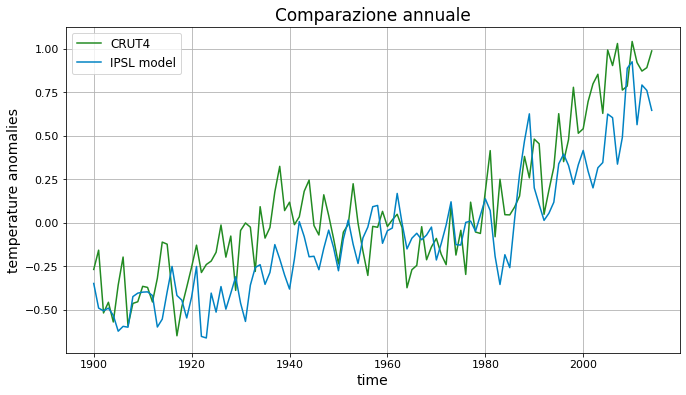

In [9]:
plt.figure(figsize = (11,6))
plt.plot(crut_y.index, crut_y.value, color = "forestgreen", label = "CRUT4")
plt.plot(ipsl_y.value, color = "#0082C3", label = "IPSL model")

plt.title("Comparazione annuale", size = 17)
plt.legend(fontsize = 12)
plt.xlabel("time", size = 14)
plt.ylabel("temperature anomalies", size = 14)
plt.xticks(size = 11)
plt.yticks(size = 11)

plt.grid()

Si può notare anche graficamente che le due serie di anomalie hanno comportamento simile. Verifichiamo l'indipendenza tra le due medie tramite un ``t-test``

In [10]:
t, p_value_t = stats.ttest_ind(crut_y.value, ipsl_y.value, equal_var = False)
print(f"T-test = {round(t,4)}, p-value = {round(p_value_t,4)}")

T-test = 2.8594, p-value = 0.0046


Con un p value decisamente significativo rifiutiamo l'ipotesi nulla di indipendenza tra le due serie.

Valutiamo ora tramite il coefficiente di ``pearson`` il grado di correlazione.

In [11]:
s, p_value_s = stats.pearsonr(crut_y.value, ipsl_y.value)
print(f"Pearson = {round(s,4)}, p-value = {round(p_value_s,4)}")

Pearson = 0.8381, p-value = 0.0


Con un p-value < 0.05 abbiamo che le due serie storiche sono correlate con un coefficiente di pearson consistente che indica proporzionalità diretta, al crescere di una cresce anche l'altra.

## Comparazione serie storiche mensili
Per una comparazione più approfondita si visualizzano le serie storiche mese per mese

In [12]:
crut_m = []
for i in range(12):
    crut_m.append(crut[crut.index.month == i+1])

In [13]:
ipsl_m = []
for i in range(12):
    ipsl_m.append(ipsl[ipsl.index.month == i+1])

In [14]:
mese = ['Gennaio', 'Febbraio', 'Marzo', 'Aprile', 'Maggio', 'Giugno', 'Luglio', 
        'Agosto', 'Settembre', 'Ottobre', 'Novembre', 'Dicembre']

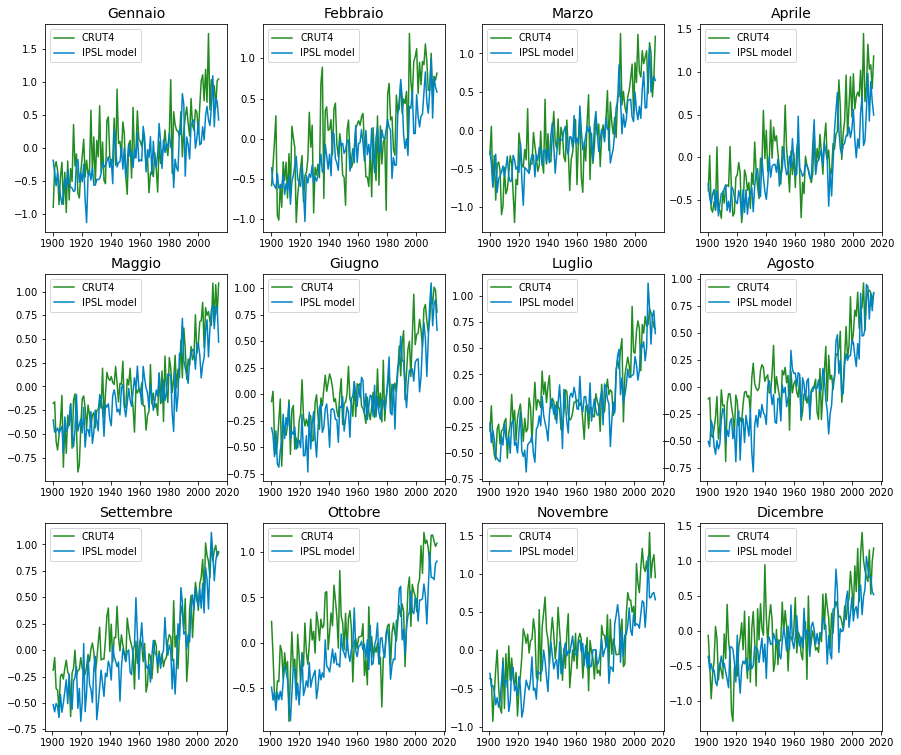

In [15]:
plt.subplots(nrows=3, ncols=4, figsize=(15,13))

for i in range(12):
    plt.subplot(3,4,i+1)
    plt.plot(crut_m[i].index, crut_m[i].value, color = "forestgreen", label = "CRUT4")
    plt.plot(ipsl_m[i].value, color = "#0082C3", label = "IPSL model")
    plt.title(mese[i], fontsize = 14)
    plt.legend(fontsize = 10)

Si può notare graficamente che l'andamento delle due serie storiche sono associabili. Ovviamente Crut4 ha andamenti più ballerini in quanto si basa su dati reali.

### T-test di indipendenza

In [16]:
for i in range(12):
    t, p_value = stats.ttest_ind(crut_m[i].value, ipsl_m[i].value, equal_var = False)
    print(f"{mese[i]}, t = {round(t,4)}, p-value = {round(p_value,4)}")

Gennaio, t = 3.1149, p-value = 0.0021
Febbraio, t = 2.6335, p-value = 0.0091
Marzo, t = 1.0862, p-value = 0.2787
Aprile, t = 2.7801, p-value = 0.0059
Maggio, t = 1.5644, p-value = 0.1191
Giugno, t = 2.5483, p-value = 0.0115
Luglio, t = 2.1778, p-value = 0.0304
Agosto, t = 2.9159, p-value = 0.0039
Settembre, t = 2.5114, p-value = 0.0127
Ottobre, t = 4.1792, p-value = 0.0
Novembre, t = 3.2494, p-value = 0.0013
Dicembre, t = 2.375, p-value = 0.0184


In [17]:
for i in range(12):
    s, p_value = stats.pearsonr(crut_m[i].value, ipsl_m[i].value)
    print(f"{mese[i]}, pearson = {round(s,4)}, p-value = {round(p_value,4)}")

Gennaio, pearson = 0.5668, p-value = 0.0
Febbraio, pearson = 0.6782, p-value = 0.0
Marzo, pearson = 0.7321, p-value = 0.0
Aprile, pearson = 0.7539, p-value = 0.0
Maggio, pearson = 0.7792, p-value = 0.0
Giugno, pearson = 0.7906, p-value = 0.0
Luglio, pearson = 0.7857, p-value = 0.0
Agosto, pearson = 0.7637, p-value = 0.0
Settembre, pearson = 0.7931, p-value = 0.0
Ottobre, pearson = 0.6952, p-value = 0.0
Novembre, pearson = 0.6677, p-value = 0.0
Dicembre, pearson = 0.5754, p-value = 0.0


Da questi test si può notare come marzo e maggio siano i mesi più anomali, meno correlati tra i dati ed il modello. In ogni caso i coefficienti di pearson mostrano correlazioni significative quindi comunque valide.

---

# Trend Analysis
Per comprendere l'andamento generale delle anomalie si applicano delle regressioni sul trend delle serie storiche. Lo scopo dell'analisi è puramente descrittivo

## Crut

Scomposizione nelle componenti principali (metodo additivo)

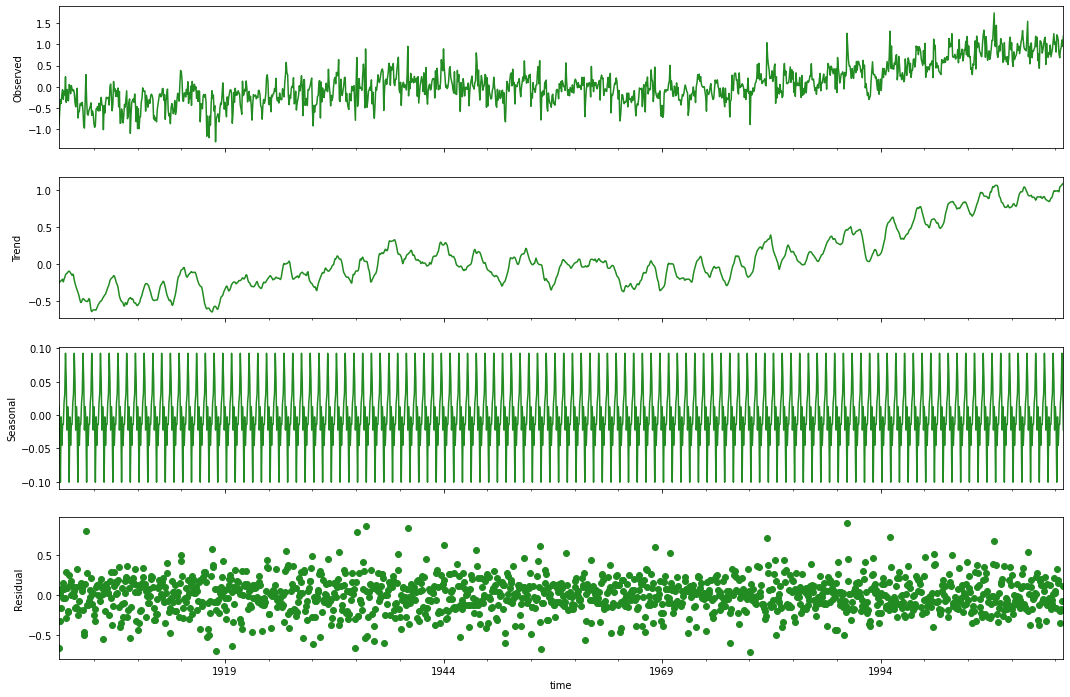

In [18]:
result_add = seasonal_decompose(crut.value, model='additive', extrapolate_trend='freq',
                               period=12)

# Plot
fig, axes = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(18,12))
result_add.observed.plot(ax=axes[0], legend=False, color = "forestgreen")
axes[0].set_ylabel('Observed')
result_add.trend.plot(ax=axes[1], legend=False, color = "forestgreen")
axes[1].set_ylabel('Trend')
result_add.seasonal.plot(ax=axes[2], legend=False, color = "forestgreen")
axes[2].set_ylabel('Seasonal')
result_add.resid.plot(ax=axes[3], legend=False, style='o', color = "forestgreen")
axes[3].set_ylabel('Residual')
plt.show()

Estrazione del trend

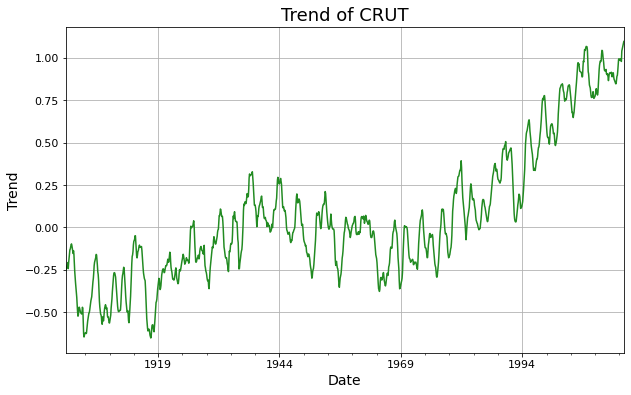

In [19]:
result_add = seasonal_decompose(crut.value, model='additive', extrapolate_trend='freq',
                               period=12)
trend = result_add.trend

fig, axes = plt.subplots(figsize=(10,6))
plt.title('Trend of CRUT', size = 18)
trend.plot(ax=axes, legend=False, color = "forestgreen")
axes.set_ylabel('Trend')
plt.xlabel("Date", fontsize=14)
plt.ylabel("Trend", fontsize=14)
plt.xticks(fontsize = 11)
plt.yticks(fontsize = 11)
plt.grid()
plt.show()

Effettuo una semplice regressione lineare

In [20]:
trend_val = trend.values
time_line = np.linspace(0, trend_val.shape[0], trend_val.shape[0])
time_line = sm.add_constant(time_line)
model = sm.OLS(trend_val, time_line).fit()

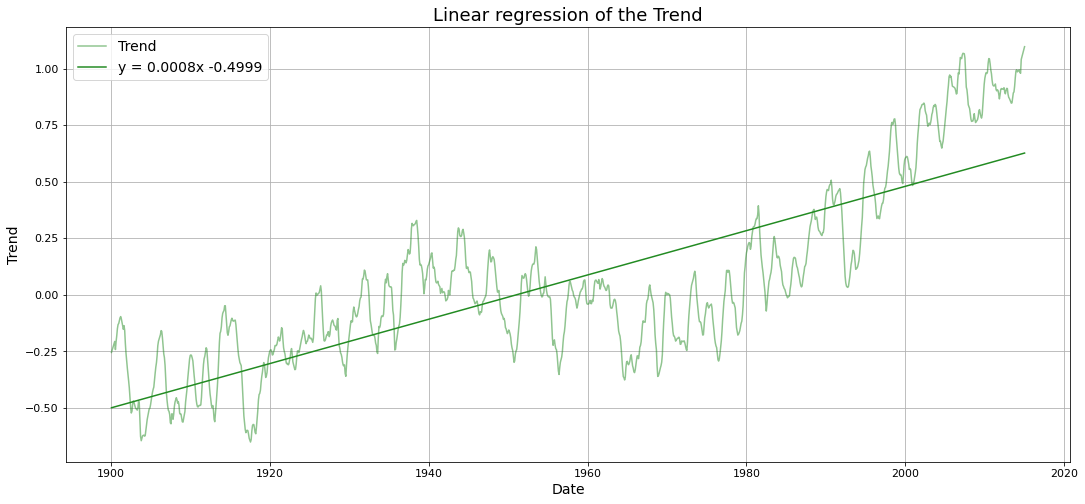

In [21]:
line_regr = model.predict(time_line)

plt.figure(figsize=(18,8))
plt.plot(trend.index, trend.values, color = "forestgreen", alpha = 0.5, label = "Trend")
plt.plot(trend.index, line_regr, color = "forestgreen",
         label = f"y = {round(model.params[1],4)}x {round(model.params[0],4)}")

plt.xticks(size = 11)
plt.yticks(size = 11)
plt.xlabel("Date", size = 14)
plt.ylabel("Trend", size = 14)
plt.title("Linear regression of the Trend", size = 18)
plt.grid(True)
plt.legend(fontsize=14)

In [22]:
print(f"r2 score è {round(model.rsquared,4)}")
print(f"Adjusted r2 score  è {round(model.rsquared_adj,4)}")

r2 score è 0.6667
Adjusted r2 score  è 0.6665


Anche una semplice regressione lineare mostra un trend chiaramente crescente. Per modellare meglio il trend si è deciso di applicare delle regressioni polionomiali in modo da apprezzare le modifiche dell'andamento nel tempo.

### Regressione polinomiale

In [23]:
# calcola la regressione di grado i dati in input x e y
def regression_polynomial(x, y, i):
    # tutte i gradi di x della regressione
    data = pd.DataFrame({'x':x, 'y':y})
    variables = ['x']
    for j in range(2, i+1):
        variables.append(f'x{j}')
        data[f'x{j}'] = data['x'] ** j
    
    X = data[variables]
    Y = data['y']

    X = sm.add_constant(X) # aggiungo la costante
    model = sm.OLS(Y, X).fit()
    
    return model

Regressioni polinomiale di 2, 3 e 4 grado

In [24]:
time_line = np.linspace(0, trend_val.shape[0], trend_val.shape[0])

model_2 = regression_polynomial(time_line, trend, 2)
model_3 = regression_polynomial(time_line, trend, 3)
model_4 = regression_polynomial(time_line, trend, 4)

In [25]:
# plot risultante dall'applicazione della regressione polinomiale
time_ax = pd.date_range(start='1900-01-01 01:00:00', end='2015-01-01 00:00:00', freq = 'M')
def plot_regression(model, time_line, value, i):
    x = np.linspace(time_line.min(), time_line.max(), len(time_line))
    label = f"y = {round(model.params['const'],3)} + {round(model.params['x'],3)}*x "
    yhat = model.params['const'] + model.params['x'] * x
    for j in range(2, i+1):
        label = label + f"+ {round(model.params[f'x{j}'],3)}*x^{j} "
        yhat += model.params[f'x{j}'] * (x**j)
    
    plt.plot(time_ax, yhat, lw=2, c='forestgreen', label = label)
    plt.plot(time_ax, value, color="forestgreen", alpha=.5)
    plt.grid(True)
    plt.legend(fontsize=11)
    plt.xlabel("Data", size=12)
    plt.ylabel("Trend", size=12)

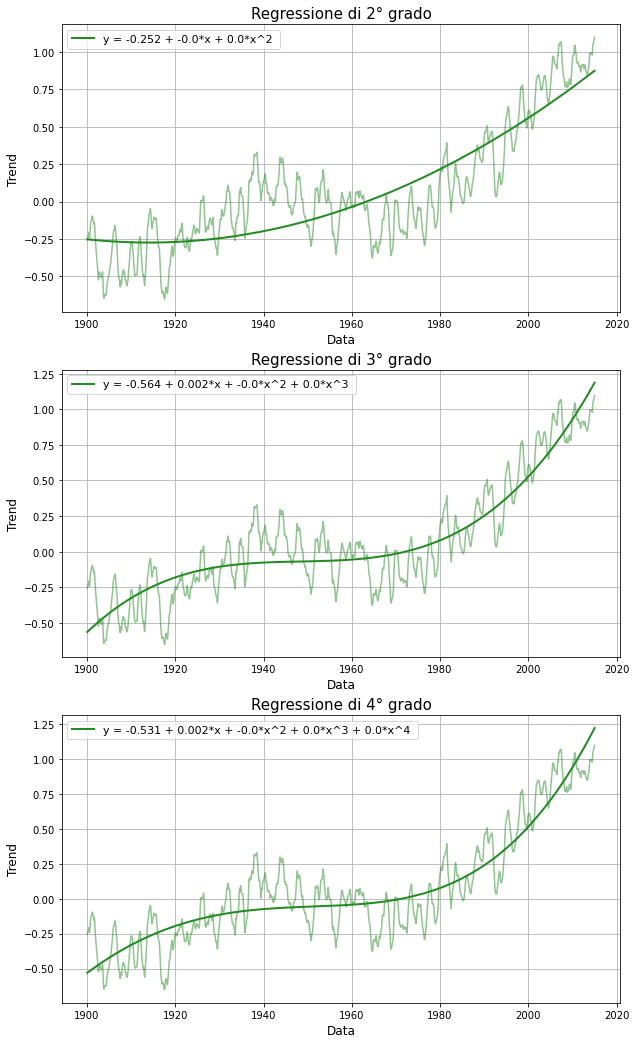

In [26]:
plt.subplots(3,1, figsize = (10,18))
for z,model_z in enumerate([model_2,model_3,model_4]):
    plt.subplot(3,1,z+1)
    plot_regression(model_z, time_line, trend, z+2)
    plt.title(f"Regressione di {z+2}° grado", size=15)

In [27]:
print(f"r2 of model base: {round(model.rsquared,4)}, r2 adjusted: {round(model.rsquared_adj,4)}")
print(f"r2 of model 2° grado: {round(model_2.rsquared,4)}, r2 adjusted: {round(model_2.rsquared_adj,4)}")
print(f"r2 of model 3° grado: {round(model_3.rsquared,4)}, r2 adjusted: {round(model_3.rsquared_adj,4)}")
print(f"r2 of model 4° grado: {round(model_4.rsquared,4)}, r2 adjusted: {round(model_4.rsquared_adj,4)}")

r2 of model base: 0.6667, r2 adjusted: 0.6665
r2 of model 2° grado: 0.7442, r2 adjusted: 0.7439
r2 of model 3° grado: 0.8326, r2 adjusted: 0.8322
r2 of model 4° grado: 0.8334, r2 adjusted: 0.8329


Si può notare che ora l'andamento della regressione fitta molto meglio il trend, anche l'indice $r^2$ ci mostra un miglioramento nello nella modellazione.

Forse il modello che meglio si adatta è quello con 3 gradi di regressione, in cui ho una parte iniziale in leggera crescita, una stazionarietà sullo 0 coincidente con il periodo di riferimento, ed infine una crescita decisa successiva agli anni 90.

## IPSL

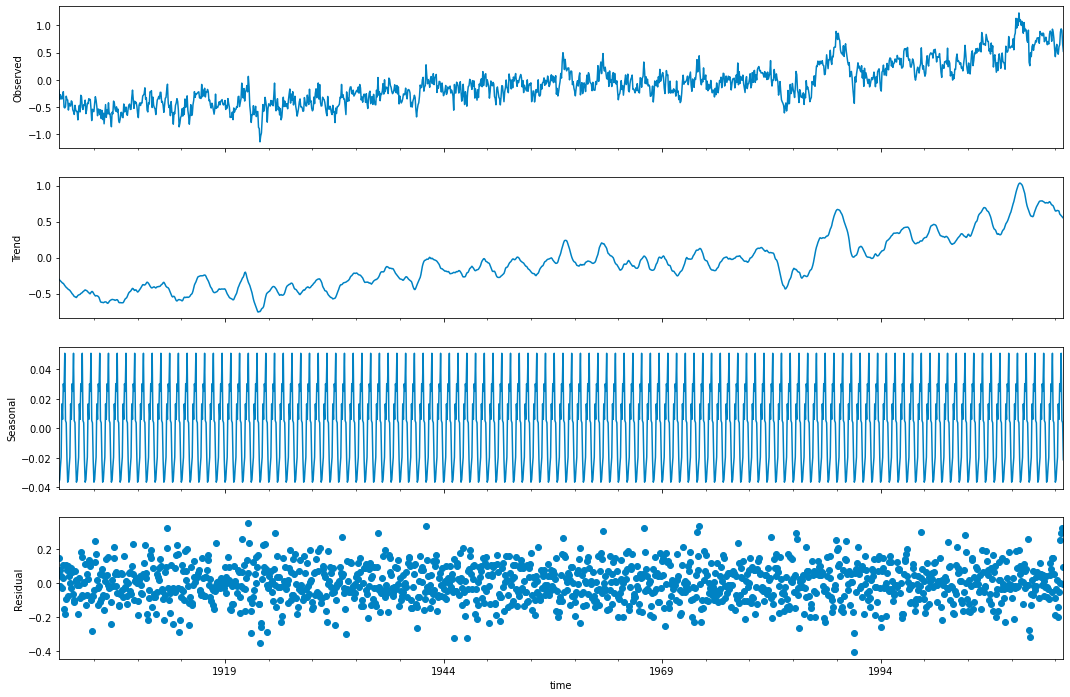

In [28]:
result_add = seasonal_decompose(ipsl.value, model='additive', extrapolate_trend='freq',
                               period=12)

# Plot
fig, axes = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(18,12))
result_add.observed.plot(ax=axes[0], legend=False, color = '#0082C3')
axes[0].set_ylabel('Observed')
result_add.trend.plot(ax=axes[1], legend=False, color = '#0082C3')
axes[1].set_ylabel('Trend')
result_add.seasonal.plot(ax=axes[2], legend=False, color = '#0082C3')
axes[2].set_ylabel('Seasonal')
result_add.resid.plot(ax=axes[3], legend=False, style='o', color = '#0082C3')
axes[3].set_ylabel('Residual')
plt.show()

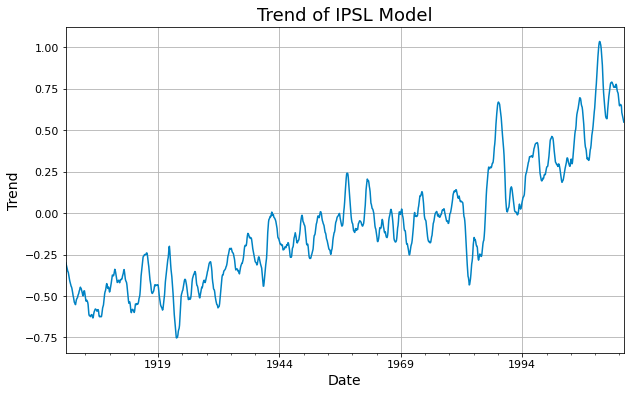

In [29]:
result_add = seasonal_decompose(ipsl.value, model='additive', extrapolate_trend='freq',
                               period=12)
trend_ipsl = result_add.trend

fig, axes = plt.subplots(figsize=(10,6))
plt.title('Trend of IPSL Model', size = 18)
trend_ipsl.plot(ax=axes, legend=False, color = '#0082C3')
axes.set_ylabel('Trend')
plt.xlabel("Date", fontsize=14)
plt.ylabel("Trend", fontsize=14)
plt.xticks(fontsize = 11)
plt.yticks(fontsize = 11)
plt.grid()
plt.show()

Si può notare un trend più smooth rispetto a quello di crut4

Effettuo una semplice regressione lineare

In [30]:
trend_ipsl_val = trend_ipsl.values
time_line = np.linspace(0, trend_ipsl_val.shape[0], trend_ipsl_val.shape[0])
time_line = sm.add_constant(time_line)
model_ipsl = sm.OLS(trend_ipsl_val, time_line).fit()

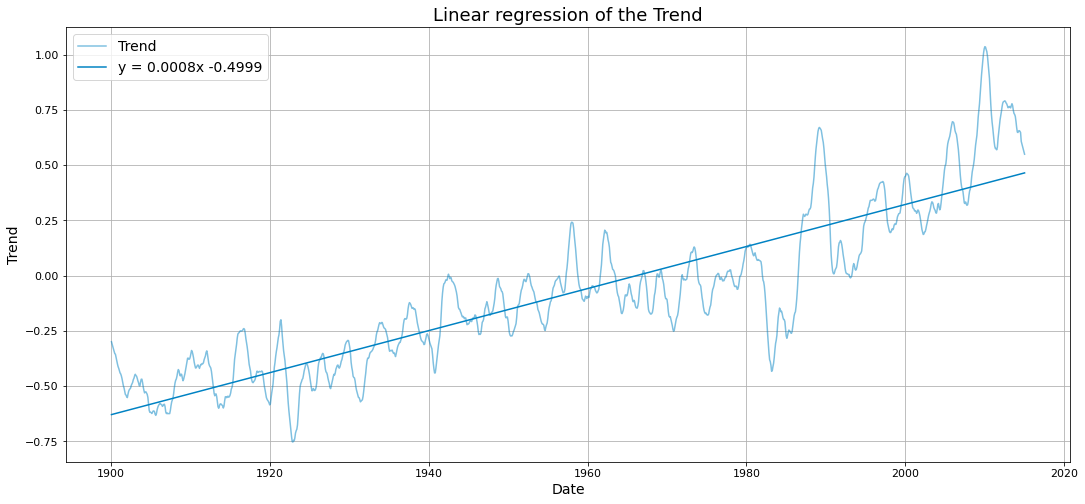

In [31]:
line_regr = model_ipsl.predict(time_line)

plt.figure(figsize=(18,8))
plt.plot(trend.index, trend_ipsl.values, color = '#0082C3', alpha=.5, label = "Trend")
plt.plot(trend.index, line_regr, color = "#0082C3", 
         label = f"y = {round(model.params[1],4)}x {round(model.params[0],4)}")

plt.xticks(size = 11)
plt.yticks(size = 11)
plt.xlabel("Date", size = 14)
plt.ylabel("Trend", size = 14)
plt.title("Linear regression of the Trend", size = 18)
plt.grid(True)
plt.legend(fontsize=14)

In [32]:
print(f"r2 score è {round(model_ipsl.rsquared,4)}")
print(f"Adjusted r2 score  è {round(model_ipsl.rsquared_adj,4)}")

r2 score è 0.7777
Adjusted r2 score  è 0.7775


Già la regressione lineare sembra essere molto efficace, però per un'analisi più approfondità, la regressione polinomiale si preferisce.

### Regressione polinomiale

In [33]:
# plot risultante dall'applicazione della regressione polinomiale
time_ax = pd.date_range(start='1900-01-01 01:00:00', end='2015-01-01 00:00:00', freq = 'M')
def plot_regression(model, time_line, value, i):
    x = np.linspace(time_line.min(), time_line.max(), len(time_line))
    label = f"y = {round(model.params['const'],3)} + {round(model.params['x'],3)}*x "
    yhat = model.params['const'] + model.params['x'] * x
    for j in range(2, i+1):
        label = label + f"+ {round(model.params[f'x{j}'],3)}*x^{j} "
        yhat += model.params[f'x{j}'] * (x**j)
    
    plt.plot(time_ax, yhat, lw=2, c='#0082C3', label = label)
    plt.plot(time_ax, value, color="#0082C3", alpha=.5)
    plt.grid(True)
    plt.legend(fontsize=11)
    plt.xlabel("Data", size=12)
    plt.ylabel("Trend", size=12)

In [34]:
time_line = np.linspace(0, trend_ipsl_val.shape[0], trend_ipsl_val.shape[0])
model_ipsl_2 = regression_polynomial(time_line, trend_ipsl, 2)
model_ipsl_3 = regression_polynomial(time_line, trend_ipsl, 3)
model_ipsl_4 = regression_polynomial(time_line, trend_ipsl, 4)

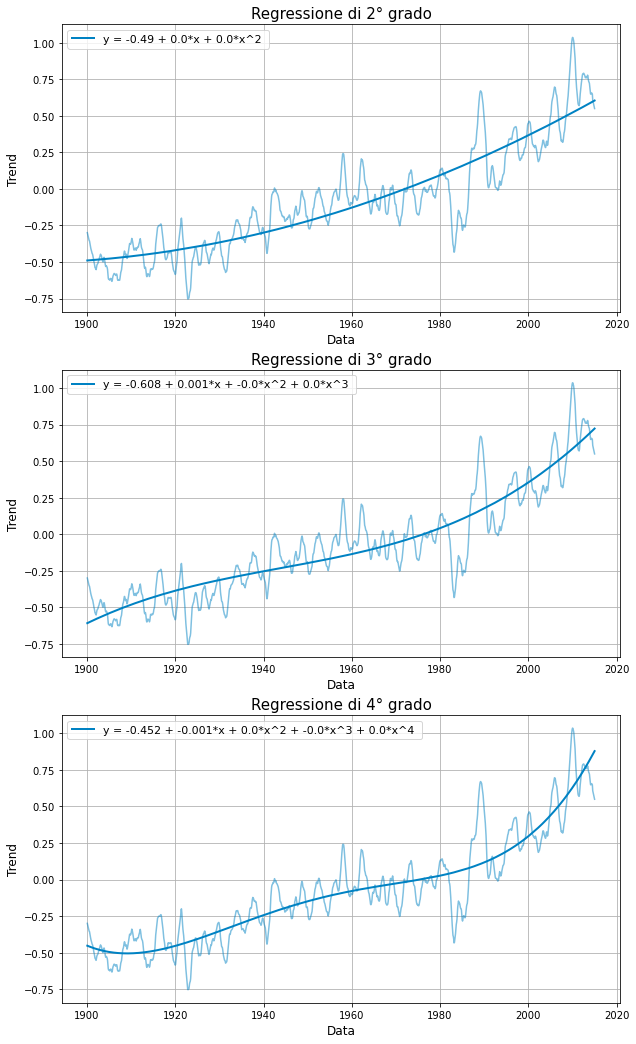

In [35]:
plt.subplots(3,1, figsize = (10,18))
for z,model_z in enumerate([model_ipsl_2,model_ipsl_3,model_ipsl_4]):
    plt.subplot(3,1,z+1)
    plot_regression(model_z, time_line, trend_ipsl, z+2)
    plt.title(f"Regressione di {z+2}° grado", size=15)

In [36]:
print(f"r2 of model base: {round(model_ipsl.rsquared,4)}, r2 adjusted: {round(model_ipsl.rsquared_adj,4)}")
print(f"r2 of model 2° grado: {round(model_ipsl_2.rsquared,4)}, r2 adjusted: {round(model_ipsl_2.rsquared_adj,4)}")
print(f"r2 of model 3° grado: {round(model_ipsl_3.rsquared,4)}, r2 adjusted: {round(model_ipsl_3.rsquared_adj,4)}")
print(f"r2 of model 4° grado: {round(model_ipsl_4.rsquared,4)}, r2 adjusted: {round(model_ipsl_4.rsquared_adj,4)}")

r2 of model base: 0.7777, r2 adjusted: 0.7775
r2 of model 2° grado: 0.8081, r2 adjusted: 0.8078
r2 of model 3° grado: 0.8238, r2 adjusted: 0.8235
r2 of model 4° grado: 0.8452, r2 adjusted: 0.8448


Anche in questo caso la versione polinomiale offre un miglior fitting dei dati e una maggior aderenza all'andamento della serie storica. In particolare la versione al 4°.

## Trend regression comparison

Si effettua quindi la comparazione delle regressioni dei trend con il fitting al 4° di x.

Text(0, 0.5, 'Trend')

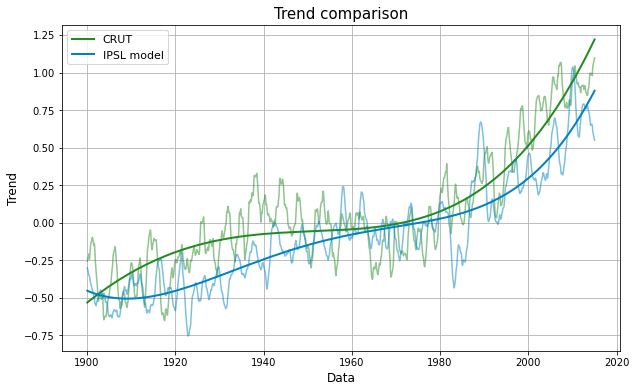

In [37]:
time_ax = pd.date_range(start='1900-01-01 01:00:00', end='2015-01-01 00:00:00', freq = 'M')

# crut trend
time_line = np.linspace(0, trend_val.shape[0], trend_val.shape[0])
x = np.linspace(time_line.min(), time_line.max(), len(time_line))

yhat = model_4.params['const'] + model_4.params['x'] * x
for j in range(2, 5):
    yhat += model_4.params[f'x{j}'] * (x**j)

    
# ipsl trend
time_line = np.linspace(0, trend_ipsl_val.shape[0], trend_ipsl_val.shape[0])
x = np.linspace(time_line.min(), time_line.max(), len(time_line))

yhat_ipsl = model_ipsl_4.params['const'] + model_ipsl_4.params['x'] * x
for j in range(2, 5):
    yhat_ipsl += model_ipsl_4.params[f'x{j}'] * (x**j)

plt.subplots(figsize=(10,6))
# crut trned
plt.plot(time_ax, yhat, lw=2, c='forestgreen', label = 'CRUT')
plt.plot(time_ax, trend, color='forestgreen', alpha=0.5)
# ipsl trend
plt.plot(time_ax, yhat_ipsl, lw=2, c='#0082C3', label = 'IPSL model')
plt.plot(time_ax, trend_ipsl, color='#0082C3', alpha=0.5)

plt.title("Trend comparison", size=15)
plt.grid(True)
plt.legend(fontsize=11)
plt.xlabel("Data", size=12)
plt.ylabel("Trend", size=12)

In [38]:
t, p_value_t = stats.ttest_ind(trend, trend_ipsl, equal_var = False)
print(f"T-test = {round(t,4)}, p-value = {round(p_value_t,4)}")
s, p_value_s = stats.pearsonr(trend, trend_ipsl)
print(f"Pearson = {round(s,4)}, p-value = {round(p_value_s,4)}")

T-test = 10.0691, p-value = 0.0
Pearson = 0.8365, p-value = 0.0


---

---

# Arima modeling

## Crut

Vediamo Acf e Pacf per valutare la tipologia di Arima necessario

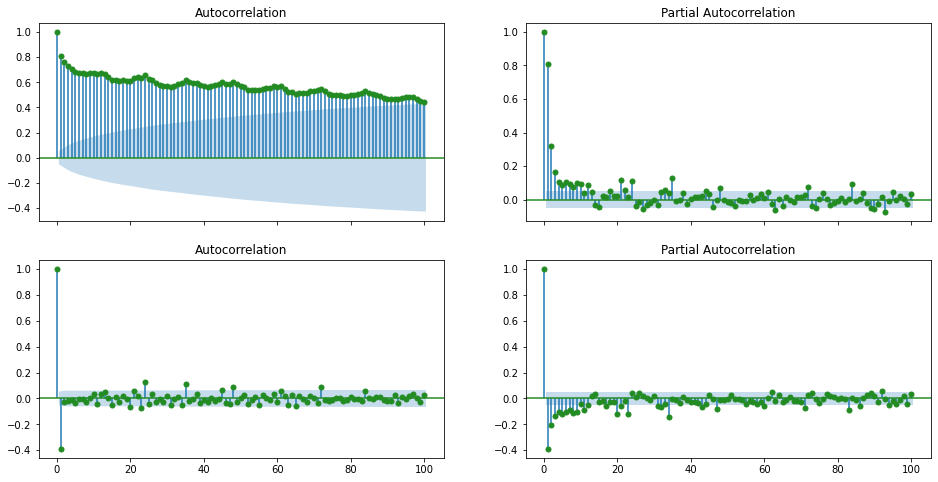

In [39]:
_, axes = plt.subplots(2,2, sharex=True, figsize=(16,8))
plot_acf(crut, lags=100, ax=axes[0][0], color = 'forestgreen')
plot_acf(crut.diff().dropna(), lags=100, ax=axes[1][0], color = 'forestgreen')
plot_pacf(crut, lags=100, ax=axes[0][1], color = 'forestgreen')
plot_pacf(crut.diff().dropna(), lags=100, ax=axes[1][1], color = 'forestgreen')
plt.show()

**Split** training set e test set. Test set ultimi 3 anni (2012-2014).

In [40]:
crut_train = crut.iloc[:-36] 
crut_test = crut.iloc[-36:]

In [41]:
smodel = pm.auto_arima(crut_train, start_p = 1, start_q = 1, max_p = 3, max_q = 3,
                       start_P=1, start_Q = 1, max_P = 2, max_Q = 2, D = 1, d = 1,
                       m = 12, max_order = None, seasonal = True, 
                       test='adf', trace = True, error_action='ignore',  
                       suppress_warnings = True, 
                       stepwise = True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=1.60 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1296.184, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=624.707, Time=0.33 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.73 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1071.092, Time=0.07 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=522.488, Time=0.65 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=1.93 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.96 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=756.517, Time=0.31 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=438.030, Time=0.59 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=540.356, Time=0.45 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=2.79 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=1.44 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=399.811, Time=0.94 sec
 ARIMA(3,1,0)(1,1,0)[12]             : AIC=501.154, Tim

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 1344
Model:             SARIMAX(3, 1, 0)x(2, 1, 0, 12)   Log Likelihood                -193.905
Date:                            Thu, 24 Jun 2021   AIC                            399.811
Time:                                    09:55:55   BIC                            430.973
Sample:                                         0   HQIC                           411.489
                                           - 1344                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5497      0.023    -24.180      0.000      -0.594      -0.505
ar.L2         -0.3392      0.028    -11.963      0.000      -0.395      -0.284
ar.L3         -0.1734      0.029     -6.059      0.000      -0.229      -0.117
ar.S.L12      -0.6919      0.020    -34.529      0.000      -0.731      -0.653
ar.S.L24      -0.2771      0.022    -12.376      0.000      -0.321      -0.233
sigma2         0.0780      0.002     31.804      0.000       0.073       0.083
===================================================================================
Ljung-Box (L1) (Q):                   0.66   Jarque-Bera (JB):               101.27
Prob(Q):                              0.42   Prob(JB):                         0.00
Heteroskedasticity (H):               0.69   Skew:                            -0.03
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Prediction

In [42]:
# set timeline to predict
future = pd.date_range(start='2012-01-01 01:00:00', end='2015-01-01 00:00:00', freq = 'M')

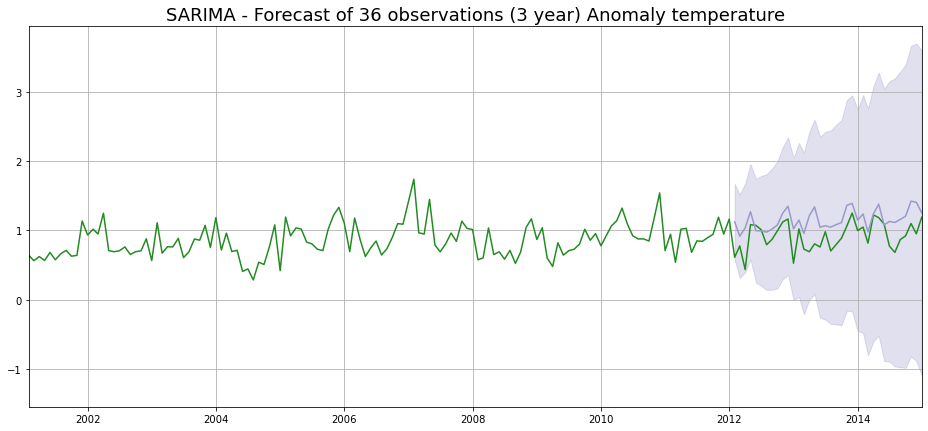

In [43]:
# Forecast
n_periods = 36
fitted, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(crut.index[-1], periods=n_periods, freq='M')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.figure(figsize=(16, 7))

plt.plot(crut.index, crut.value, color = 'forestgreen')

plt.plot(future, fitted_series, color='#9999CC')
plt.fill_between(future, 
                 lower_series, 
                 upper_series, 
                 color='#9999CC', alpha=.3)
plt.xlim(crut_train.index[-132], future[-1]) 
plt.grid()
plt.title("SARIMA - Forecast of 36 observations (3 year) Anomaly temperature", size = 18)
plt.show()

In [44]:
mse = mean_squared_error(fitted_series, crut_test)
mae = mean_absolute_error(fitted_series, crut_test)
s, p_value = stats.pearsonr(np.array(fitted_series), crut_test.value.values)

print(f"MSE: {round(mse,4)}")
print(f"MAE: {round(mae,4)}")
print(f"Pearson: {round(s,4)}, p-value: {round(p_value,4)}")

MSE: 0.084
MAE: 0.2431
Pearson: 0.5666, p-value: 0.0003


Graficamente si nota una lieve sovrastima generale della serie storica. Il CI, come ci si aspetta, si amplia man mano che si procede con il forecasting.

Vedendo i risultati delle performance abbiamo un mse decisamente basso ma un mae un può più elevanto, però pari a solo 0.34 gradi di anomalia. Direi molto soddisfaciente come modello.

Inoltre il coefficiente di pearson ci definisce un legame importante tra la serie predetta e quella reale.

### 12 Arima mensili

**Split** training e test set

In [45]:
crut_m_train = []
crut_m_test = []
for month in range(12):
    crut_m_train.append(crut_m[month][:-3]) 
    crut_m_test.append(crut_m[month][-3:])

In [46]:
arimas = list()
for month in range(12):
    print(" ------------------------ ")
    print(f"Computing ARIMA month {month}")
    print(" ------------------------ ")
    arima_current = pm.auto_arima(crut_m_train[month], start_p = 1, start_q = 1, max_p = 3, max_q = 3,
                       max_d = 1, P = 0, Q = 0, D = 0,
                       max_order = None, seasonal = False, 
                       test='adf', trace = True, error_action='ignore',  
                       suppress_warnings = True, 
                       stepwise = True)
    arimas.append(arima_current)

 ------------------------ 
Computing ARIMA month 0
 ------------------------ 
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=99.402, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=172.643, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=122.341, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=101.079, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=170.758, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=101.021, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=100.252, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=99.869, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=116.005, Time=0.02 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=102.226, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=100.623, Time=0.02 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 0.518 seconds
 ------------------------ 
Computing ARIMA month 1
 ------------------------ 
Performing 

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=61.346, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=104.599, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=63.295, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=63.263, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=62.564, Time=0.01 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.324 seconds
 ------------------------ 
Computing ARIMA month 11
 ------------------------ 
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=98.291, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=145.913, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=118.669, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=96.687, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=143.978, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=98.344, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=100.535, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0]     

#### Prediction

In [47]:
# set timeline to predict
future = pd.date_range(start='2012-01-01 01:00:00', end='2015-01-01 00:00:00', freq = 'M')

n_periods = 3
fitted = np.array([])
confint = list()
index_of_fc = list()
fitted_series = pd.DataFrame({})
lower_series = pd.DataFrame({})
upper_series = pd.DataFrame({})

for month in range(12):
    fitted_c, confint_c = arimas[month].predict(n_periods=n_periods, return_conf_int=True)
    index_of_fc_c = pd.date_range(crut_m_train[month].index[-1] + relativedelta(years=1), 
                                  periods=n_periods, freq='12M')
    # make series for plotting purpose
    fitted_series_c = pd.Series(fitted_c, index=index_of_fc_c)
    lower_series_c = pd.Series(confint_c[:, 0], index=index_of_fc_c)
    upper_series_c = pd.Series(confint_c[:, 1], index=index_of_fc_c)
    
    fitted = np.concatenate((fitted, fitted_c))
    confint.append(confint_c)
    index_of_fc.append(index_of_fc_c)
    fitted_series = pd.concat([fitted_series, fitted_series_c], axis=0).sort_index()
    lower_series = pd.concat([lower_series, lower_series_c], axis=0).sort_index()
    upper_series = pd.concat([upper_series, upper_series_c], axis=0).sort_index()

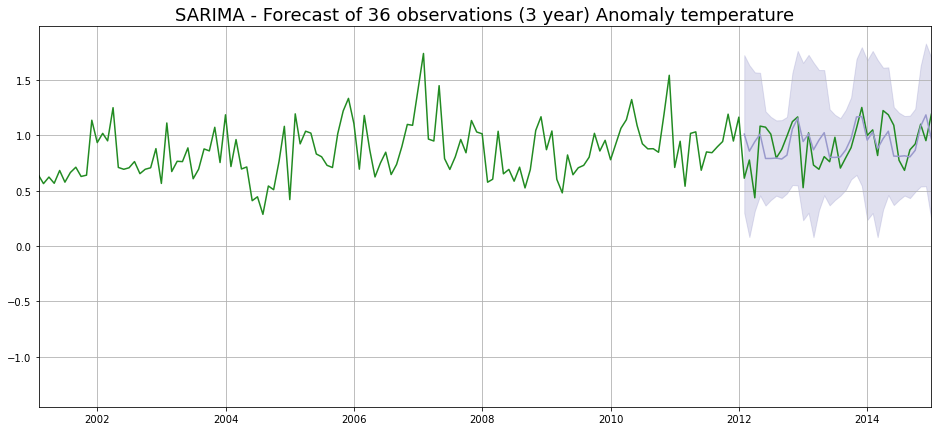

In [48]:
plt.figure(figsize=(16, 7))

plt.plot(crut.index, crut.value, color = 'forestgreen')

plt.plot(fitted_series.index, fitted_series.values, color='#9999CC')
plt.fill_between(fitted_series.index, 
                 lower_series[0].values, 
                 upper_series[0].values, 
                 color='#9999CC', alpha=.3)
plt.xlim(crut_train.index[-132], future[-1]) 
plt.grid()
plt.title("SARIMA - Forecast of 36 observations (3 year) Anomaly temperature", size = 18)
plt.show()

In [49]:
mse = mean_squared_error(fitted_series, crut_test)
mae = mean_absolute_error(fitted_series, crut_test)
s, p_value = stats.pearsonr(fitted_series[0].values, crut_test.value.values)

print(f"MSE: {round(mse,4)}")
print(f"MAE: {round(mae,4)}")
print(f"Pearson: {round(s,4)}, p-value: {round(p_value,4)}")

MSE: 0.0355
MAE: 0.1433
Pearson: 0.399, p-value: 0.0159


Tramite questa soluzione abbiamo un forecast molto più performante, con un CI ristretto ma comunque contiene tutti i valori reali della serie storica. 

Le performance sono decisamente migliorate, anche se il coefficiente di pearson non segnala correlazione tra la serie predetta con quella reale. 

## Model IPSL

Vediamo Acf e Pacf per valutare la tipologia di Arima necessario

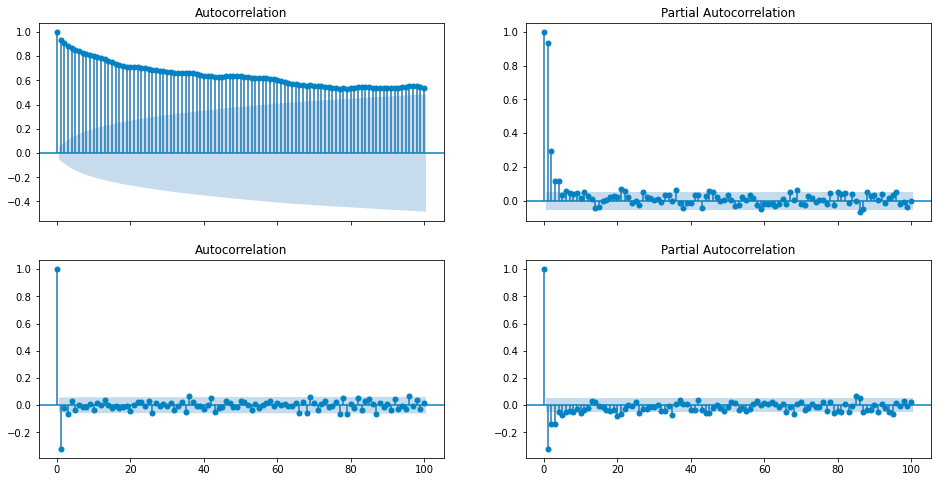

In [50]:
_, axes = plt.subplots(2,2, sharex=True, figsize=(16,8))
plot_acf(ipsl, lags=100, ax=axes[0][0], color = '#0082C3')
plot_acf(ipsl.diff().dropna(), lags=100, ax=axes[1][0], color = '#0082C3')
plot_pacf(ipsl, lags=100, ax=axes[0][1], color = '#0082C3')
plot_pacf(ipsl.diff().dropna(), lags=100, ax=axes[1][1], color = '#0082C3')
plt.show()

Split training and test set

In [51]:
ipsl_train = ipsl.iloc[:-36] 
ipsl_test = ipsl.iloc[-36:]

In [52]:
smodel = pm.auto_arima(ipsl_train, start_p = 1, start_q = 1, max_p = 3, max_q = 3,
                       start_P=1, start_Q = 1, max_P = 2, max_Q = 2, D = 1, d = 1,
                       m = 12, max_order = None, seasonal = True, 
                       test='adf', trace = True, error_action='ignore',  
                       suppress_warnings = True, 
                       stepwise = True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=1.79 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-536.615, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-1074.409, Time=0.32 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=1.17 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=-713.720, Time=0.05 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=-1270.857, Time=0.74 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=2.60 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=1.23 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=-1104.716, Time=0.48 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=-1300.986, Time=1.06 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=-1100.217, Time=0.51 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=3.59 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=1.31 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=-1325.028, Time=1.09 sec
 ARIMA(3,1,0)(1,1,0)[12]             : AIC=

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                 1344
Model:             SARIMAX(1, 1, 1)x(2, 1, [], 12)   Log Likelihood                 669.841
Date:                             Thu, 24 Jun 2021   AIC                          -1329.682
Time:                                     09:57:25   BIC                          -1303.714
Sample:                                          0   HQIC                         -1319.950
                                            - 1344                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1638      0.057      2.855      0.004       0.051       0.276
ma.L1         -0.5912      0.046    -12.882      0.000      -0.681      -0.501
ar.S.L12      -0.6782      0.025    -26.784      0.000      -0.728      -0.629
ar.S.L24      -0.3801      0.025    -15.018      0.000      -0.430      -0.331
sigma2         0.0213      0.001     25.991      0.000       0.020       0.023
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 0.16
Prob(Q):                              0.89   Prob(JB):                         0.92
Heteroskedasticity (H):               1.02   Skew:                             0.02
Prob(H) (two-sided):                  0.87   Kurtosis:                         3.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

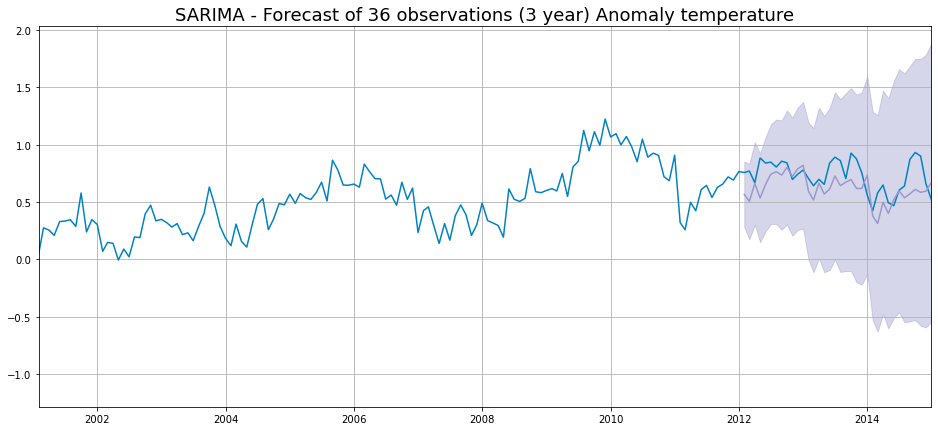

In [53]:
# set timeline to predict
future = pd.date_range(start='2012-01-01 01:00:00', end='2015-01-01 00:00:00', freq = 'M')

# Forecast
n_periods = 36
fitted, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(ipsl.index[-1], periods=n_periods, freq='M')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.figure(figsize=(16, 7))

plt.plot(ipsl.index, ipsl.value, color = '#0082C3')

plt.plot(future, fitted_series, color='#9999CC')
plt.fill_between(future, 
                 lower_series, 
                 upper_series, 
                 color='#9999CC', alpha=.4)
plt.xlim(ipsl_train.index[-132], future[-1]) 
plt.grid()
plt.title("SARIMA - Forecast of 36 observations (3 year) Anomaly temperature", size = 18)
plt.show()

In [54]:
mse = mean_squared_error(fitted_series, ipsl_test)
mae = mean_absolute_error(fitted_series, ipsl_test)
s, p_value = stats.pearsonr(np.array(fitted_series), ipsl_test.value.values)

print(f"MSE: {round(mse,4)}")
print(f"MAE: {round(mae,4)}")
print(f"Pearson: {round(s,4)}, p-value: {round(p_value,4)}")

MSE: 0.0296
MAE: 0.1411
Pearson: 0.4817, p-value: 0.0029


Graficamente possiamo notare come la previsione si avvicini molto alla serie osservata.

Le performance sono molto buone, con un coefficiente di pearson che non segnala correlazione significativa.

### Arima mensili

Split training e test set

In [55]:
ipsl_m_train = []
ipsl_m_test = []
for month in range(12):
    ipsl_m_train.append(ipsl_m[month][:-3]) 
    ipsl_m_test.append(ipsl_m[month][-3:])

In [56]:
arimas = list()
for month in range(12):
    print(" ------------------------ ")
    print(f"Computing ARIMA month {month}")
    print(" ------------------------ ")
    arima_current = pm.auto_arima(ipsl_m_train[month], start_p = 1, start_q = 1, max_p = 3, max_q = 3,
                       max_d = 1, P = 0, Q = 0, D = 0,
                       max_order = None, seasonal = False, 
                       test='adf', trace = True, error_action='ignore',  
                       suppress_warnings = True, 
                       stepwise = True)
    arimas.append(arima_current)

 ------------------------ 
Computing ARIMA month 0
 ------------------------ 
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=23.963, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=116.506, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=47.341, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=76.570, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=24.818, Time=0.09 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=24.695, Time=0.06 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=65.315, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=39.606, Time=0.03 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=21.256, Time=0.09 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=23.240, Time=0.11 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=23.242, Time=0.14 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=26.540, Time=0.07 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=26.565, Time=0.06 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=26.6

 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-40.929, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-44.426, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-42.850, Time=0.06 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-42.432, Time=0.13 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-42.430, Time=0.11 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-42.603, Time=0.10 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-40.426, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-40.000, Time=0.07 sec

Best model:  ARIMA(1,1,2)(0,0,0)[0] intercept
Total fit time: 0.895 seconds
 ------------------------ 
Computing ARIMA month 9
 ------------------------ 
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-55.093, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-17.816, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-29.725, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-52.465, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0

#### Prediction

In [57]:
# set timeline to predict
future = pd.date_range(start='2012-01-01 01:00:00', end='2015-01-01 00:00:00', freq = 'M')

n_periods = 3
fitted = np.array([])
confint = list()
index_of_fc = list()
fitted_series = pd.DataFrame({})
lower_series = pd.DataFrame({})
upper_series = pd.DataFrame({})

for month in range(12):
    fitted_c, confint_c = arimas[month].predict(n_periods=n_periods, return_conf_int=True)
    index_of_fc_c = pd.date_range(ipsl_m_train[month].index[-1] + relativedelta(years=1), 
                                  periods=n_periods, freq='12M')
    # make series for plotting purpose
    fitted_series_c = pd.Series(fitted_c, index=index_of_fc_c)
    lower_series_c = pd.Series(confint_c[:, 0], index=index_of_fc_c)
    upper_series_c = pd.Series(confint_c[:, 1], index=index_of_fc_c)
    
    fitted = np.concatenate((fitted, fitted_c))
    confint.append(confint_c)
    index_of_fc.append(index_of_fc_c)
    fitted_series = pd.concat([fitted_series, fitted_series_c], axis=0).sort_index()
    lower_series = pd.concat([lower_series, lower_series_c], axis=0).sort_index()
    upper_series = pd.concat([upper_series, upper_series_c], axis=0).sort_index()

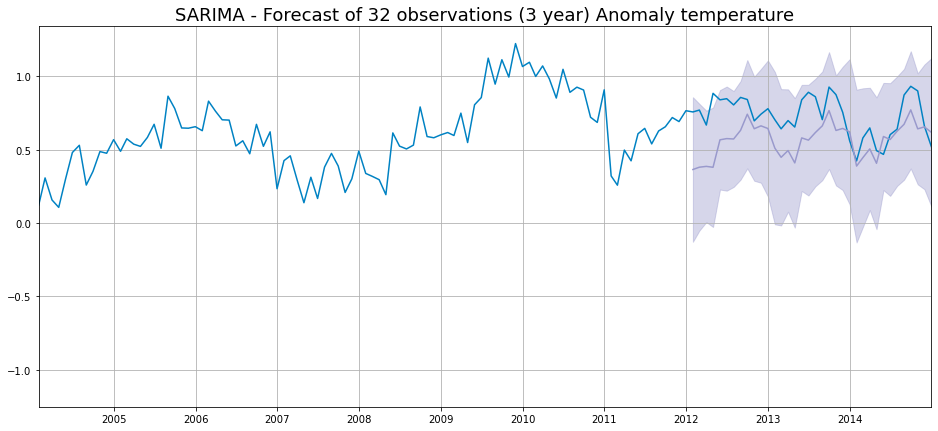

In [58]:
plt.figure(figsize=(16, 7))

plt.plot(ipsl.index, ipsl.value, color = '#0082C3')

plt.plot(fitted_series.index, fitted_series.values, color='#9999CC')
plt.fill_between(fitted_series.index, 
                 lower_series[0].values, 
                 upper_series[0].values, 
                 color='#9999CC', alpha=.4)
plt.xlim(ipsl.index[-132], future[-1]) 
plt.grid()
plt.title("SARIMA - Forecast of 32 observations (3 year) Anomaly temperature", size = 18)
plt.show()

In [59]:
mse = mean_squared_error(fitted_series, ipsl_test)
mae = mean_absolute_error(fitted_series, ipsl_test)
s, p_value = stats.pearsonr(fitted_series[0].values, ipsl_test.value.values)

print(f"MSE: {round(mse,4)}")
print(f"MAE: {round(mae,4)}")
print(f"Pearson: {round(s,4)}, p-value: {round(p_value,4)}")

MSE: 0.0458
MAE: 0.1809
Pearson: 0.4165, p-value: 0.0115


Graficamente si può notare come la serie venga leggermente sottostimata. Anche le performance sembrano essere leggermente peggiorative rispetto al modello precendente (MSE 0.02; MAE 0.14). Coefficiente di pearson di pearson piuttosto basso con correlazione non marcata.